# Sensor Data from Lavaux 2022-03-08

In [19]:
import pandas as pd
import os
import glob
import numpy as np
import re
from scipy import stats
import sklearn

from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib inline

## 0. Import Temperature of all files 
readout from HOBO sensors 2022-03-08 and 2023-05-10

--> First column is temperature, second one RH

In [5]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Sensor_Data')

### Sensor metadata 

In [6]:
md = pd.read_csv('sensors_metadata.txt', sep='\t', index_col=0)

# make dict to rename the sensor names with the plot ID 
rename_columns_dict = dict(zip(md["Sensors"], md.index))


### 2021-2022

> note Lavaux_003 measured all 15 min (consider subsampling with `df['Lavaux_003'].resample('1H').mean()`)

> Sensors were installed on 2021-04-20 and read out 2022-03-08 

In [7]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Sensor_Data/2021')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]
# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,2], index_col=0) for f in all_files]
df_2022 = pd.concat(dfs, axis=1)
df_2022.index = pd.to_datetime(df_2022.index)
df_2022.set_axis(names, axis=1, inplace=True)
df_2022.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2022 = df_2022[(df_2022.index > '2021-04-21 00:30:00') & (df_2022.index < '2022-03-08 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_32844/1096892145.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2022.set_axis(names, axis=1, inplace=True)


### 2022-2023 
> note two sensors have gone missing when reading out the sensors in 2023!

In [8]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Sensor_Data/2023')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]
# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,2], index_col=0) for f in all_files]
df_2023 = pd.concat(dfs, axis=1)
df_2023.index = pd.to_datetime(df_2023.index)
df_2023.set_axis(names, axis=1, inplace=True)
df_2023.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2023 = df_2023[(df_2023.index > '2022-03-08 18:00:00') & (df_2023.index < '2023-05-10 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_32844/4110299495.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2023.set_axis(names, axis=1, inplace=True)


### Merge all data

In [9]:
df_temp = pd.concat([df_2022,df_2023], join='outer', axis=0)
df_temp.tail()

,Plot_18,Plot_15_3,Plot_4,Plot_17_1,Plot_17_5,Plot_12,Plot_17_4,Plot_20_3,Plot_9,Plot_20_5,...,Plot_17_3,Plot_15_1,Plot_15_4,Plot_14,Plot_11,Plot_20_4,Plot_17_2,Plot_15_5,Plot_13,Plot_15_2
2023-05-10 03:00:00,NaN,11.565,NaN,12.775,12.847,11.613,12.775,12.340,51.809,12.219,...,12.847,11.540,11.613,12.364,NaN,12.340,NaN,11.637,50.370,11.565
2023-05-10 04:00:00,NaN,11.783,NaN,12.074,12.316,11.710,13.257,12.703,52.455,12.582,...,13.088,11.783,12.025,12.992,NaN,12.823,NaN,11.929,-23.041,11.662
2023-05-10 05:00:00,NaN,10.443,NaN,11.224,11.419,10.467,11.565,11.005,48.471,10.883,...,11.662,10.369,10.443,11.151,NaN,10.883,NaN,10.394,47.060,10.394
2023-05-10 06:00:00,NaN,10.100,NaN,12.316,12.364,10.075,11.273,10.638,47.190,10.516,...,11.248,10.100,10.222,10.761,NaN,10.565,NaN,10.149,46.130,10.100
2023-05-10 07:00:00,NaN,10.565,NaN,12.968,13.088,10.590,12.485,11.662,49.107,11.589,...,12.534,10.541,10.614,11.613,NaN,11.686,NaN,10.663,47.580,10.541


In [10]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Sensor_Data')

In [11]:
# to have  a look
df_temp.to_csv('all_data.csv')

## 1. Intraplot variance

Plots 15, 17 and 20 have 5 sensors each and we can test whether the mean temperature per month is statistically significant between those sensors. 

> does not look like it

In [22]:
# Get a list of sensors at a specific plot and subset the datafame to only contain data from these plots 
plot_of_interest = 17

selected_plots = md.loc[md['Plots'] == plot_of_interest].index.to_list()
df_subset = df_temp[selected_plots]

# get mean temperature for each month (dropNA to do a significance test)
average_temps_subset = df_subset.resample('M').mean() #.dropna()

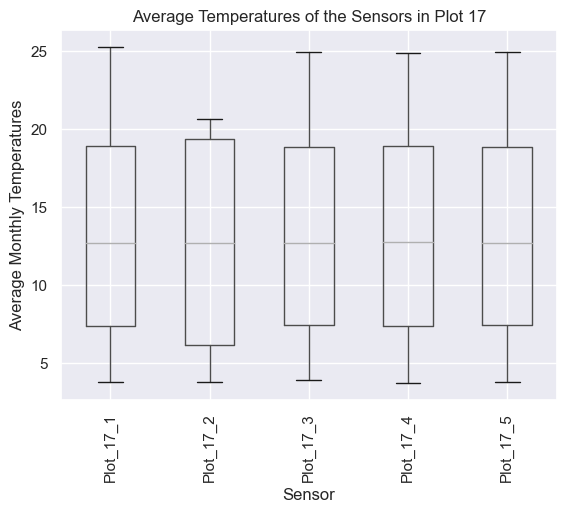

In [23]:
average_temps_subset.boxplot()

plt.xticks(rotation=90)
plt.xlabel('Sensor')
plt.ylabel('Average Monthly Temperatures')
title = 'Average Temperatures of the Sensors in Plot ' + str(plot_of_interest)
plt.title(title)

plt.show()


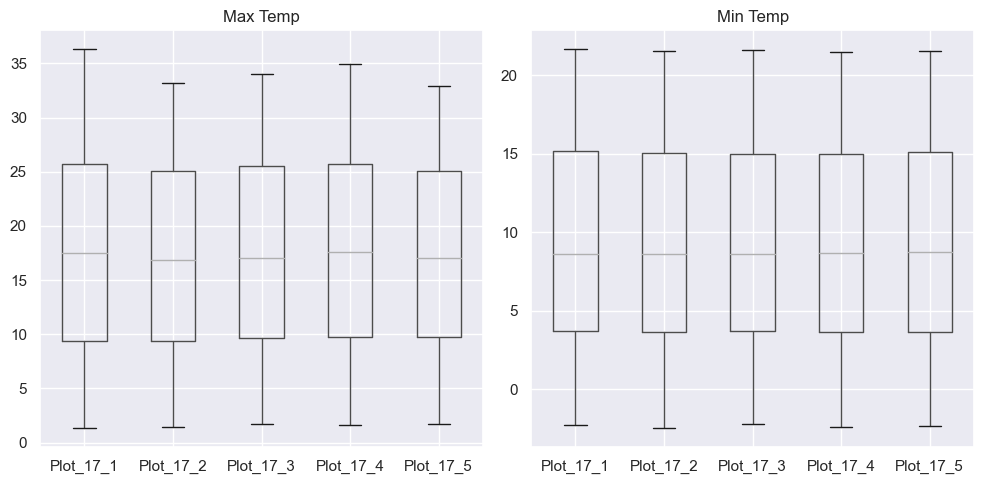

In [24]:
# compare min and max temperatures 
daily_max = df_subset.resample('D').max().dropna()
daily_min = df_subset.resample('D').min().dropna()

# two plots next to each other 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the first box plot on the first axes
daily_max.boxplot(ax=axs[0])

# Create the second box plot on the second axes
daily_min.boxplot(ax=axs[1])

# Set the title for each plot
axs[0].set_title('Max Temp')
axs[1].set_title('Min Temp')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [25]:
# Perform Kruskal-Wallis test on the rows
average_temps_subset['p-value'] = average_temps_subset.apply(lambda row: stats.kruskal(*row)[1], axis=1)
average_temps_subset

,Plot_17_1,Plot_17_2,Plot_17_3,Plot_17_4,Plot_17_5,p-value
2021-04-30,15.323782,15.315787,15.457042,15.346540,15.435979,0.406006
2021-05-31,12.831008,12.905220,12.977993,12.997720,13.012241,0.406006
2021-06-30,20.556858,20.622779,20.713967,20.793326,20.717806,0.406006
2021-07-31,21.265215,20.627546,20.774897,20.824191,20.650973,0.406006
2021-08-31,20.303962,20.365696,20.406474,20.368478,20.293652,0.406006
2021-09-30,18.921871,18.987222,18.870185,18.883781,18.847764,0.406006
2021-10-31,12.603136,12.488368,12.399246,12.460684,12.417509,0.406006
2021-11-30,6.962908,6.925842,7.025728,6.955618,6.997088,0.406006
2021-12-31,3.972977,3.986610,4.053172,3.945739,4.013218,0.406006
2022-01-31,3.781540,3.782320,3.886352,3.735672,3.774239,0.406006


## 2. Comparing all Sensors to each other

In [38]:
# get mean temperature for each month
average_temps = df_temp.resample('W').mean().dropna(axis=1)

### Statistical testing 

> mean temperatures of months / weeks are not statistically significant between each other 

In [39]:
# Perform Kruskal-Wallis test on each row
p_values = []
for _, row in average_temps.iterrows():
    _, p_value = stats.kruskal(*row.values)
    p_values.append(p_value)

# Create a new DataFrame with p-values
p_value_df = pd.DataFrame({'P-Value': p_values}, index=average_temps.index)

# Filter and print rows with significant p-values
significant_rows = p_value_df[p_value_df['P-Value'] < 0.05]
print(significant_rows)

Empty DataFrame
Columns: [P-Value]
Index: []


### Add some metadata

In [40]:
# Merge the dataframes based on the sensor name (reset the index first) and sort: first by altitude and then by plot 
ave_temp_new = average_temps.reset_index() 
md_renamed = md.reset_index()
#merged_df = ave_temp_new.merge(md_renamed, left_on=ave_temp_new.columns, right_on='ID')

merged_df = ave_temp_new.melt(id_vars='index', var_name='ID', value_name='Temperature').merge(md, on='ID').sort_values(by = ['Altitude', 'ID'])
merged_df

,index,ID,Temperature,Sensors,Plots,Altitude,Average_slope,Exposition,Average_radiation
108,2021-04-25,Plot_17_1,18.026370,Lavaux_002,17,390,20,South-West,912.5
109,2021-05-02,Plot_17_1,11.625869,Lavaux_002,17,390,20,South-West,912.5
110,2021-05-09,Plot_17_1,12.259315,Lavaux_002,17,390,20,South-West,912.5
111,2021-05-16,Plot_17_1,11.837167,Lavaux_002,17,390,20,South-West,912.5
112,2021-05-23,Plot_17_1,11.943321,Lavaux_002,17,390,20,South-West,912.5
...,...,...,...,...,...,...,...,...,...
1939,2023-04-16,Plot_13,-2.542274,Lavaux_032,13,580,30,South-West,937.5
1940,2023-04-23,Plot_13,4.248268,Lavaux_032,13,580,30,South-West,937.5
1941,2023-04-30,Plot_13,3.829917,Lavaux_032,13,580,30,South-West,937.5
1942,2023-05-07,Plot_13,10.377952,Lavaux_032,13,580,30,South-West,937.5


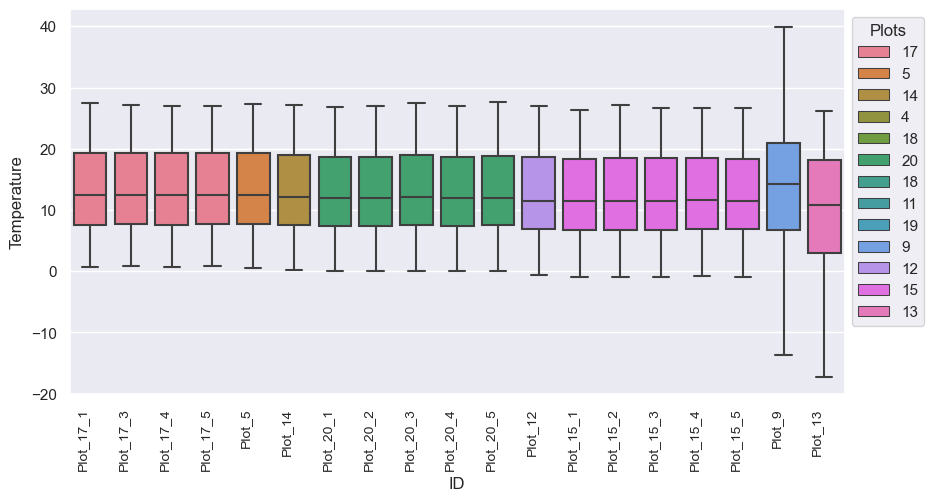

In [41]:
plt.figure(figsize=(10,5))

plots_ordered_by_altitude = [17, 5, 14, 4, 18, 20, 18, 11, 19, 9, 12, 15, 13]

ax = sns.boxplot(x='ID', y='Temperature', hue="Plots", 
                 width=0.8, dodge=False,
                 data=merged_df, palette="husl", 
                 hue_order=plots_ordered_by_altitude,
                 showfliers = False
                 )

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
)
None
# the None is to not show the lables as output 

### Compare the night and day temperatures

In [43]:
# Define the start and end times for day and night
day_start_time = pd.to_datetime('6:00:00').time()
day_end_time = pd.to_datetime('18:00:00').time()

# Extract the day and night temperatures using conditional indexing
day_temperatures = df_temp[df_temp.index.time >= day_start_time].resample('D').mean()
night_temperatures = df_temp[df_temp.index.time < day_start_time].resample('D').mean()

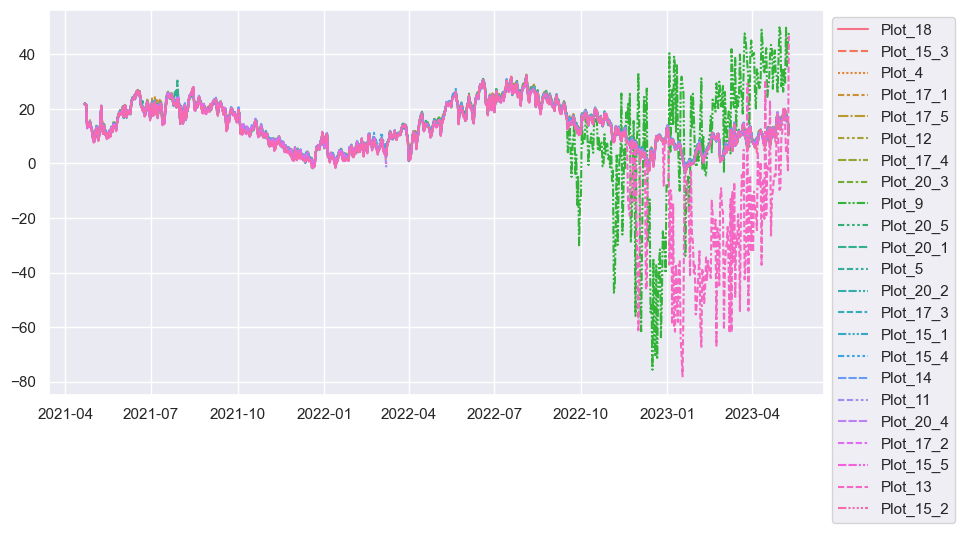

In [44]:
plt.figure(figsize=(10,5))


ax = sns.lineplot(
                    #df_temp[(df_temp.index > '2022-02-01') & (df_temp.index < '2022-04-01')].resample('W').median()
                    #df_temp.resample('D').mean().dropna()
                    
                  data=day_temperatures

                 )

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# the None is to not show the lables as output 

## Growing Degree Days 

In [670]:
# check out a single year and calculate the mean values per year
df_mean_21 = df_temp[(df_temp.index > '2021-01-01') & (df_temp.index < '2021-12-31')].resample('D').mean()#.dropna()
df_mean_22 = df_temp[(df_temp.index > '2022-01-01') & (df_temp.index < '2022-12-31')].resample('D').mean()#.dropna()

In [34]:
# base temperature of 10 °C --> subtract from the mean temperature and sum up 
base_temperature = 10 
GDD_21 = df_mean_21.apply(lambda x: (x - base_temperature).sum())
GDD_22 = df_mean_22.apply(lambda x: (x - base_temperature).sum())

GDD_21 = GDD_21.rename_axis('Sensors', axis="columns")

NameError: name 'df_mean_21' is not defined

In [35]:
GDD_21

NameError: name 'GDD_21' is not defined

In [335]:
md.head()

,Plots,Altitude,Average_slope,Exposition,Average_radiation,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
Sensors,,,,,,,,,,
Lavaux_016,4,450,30,South-West,937.5,NaN,NaN,NaN,NaN,NaN
Lavaux_007,5,400,30,South-West,912.5,NaN,NaN,NaN,NaN,NaN
Lavaux_004,9,520,35,South-West,887.5,NaN,NaN,NaN,NaN,NaN
Lavaux_024,11,490,20,South,937.5,NaN,NaN,NaN,NaN,NaN
Lavaux_001,12,520,15,South-West,937.5,NaN,NaN,NaN,NaN,NaN


In [337]:
all_GDDs = md.merge(GDD_21, on)

ValueError: Cannot merge a Series without a name

<AxesSubplot: >

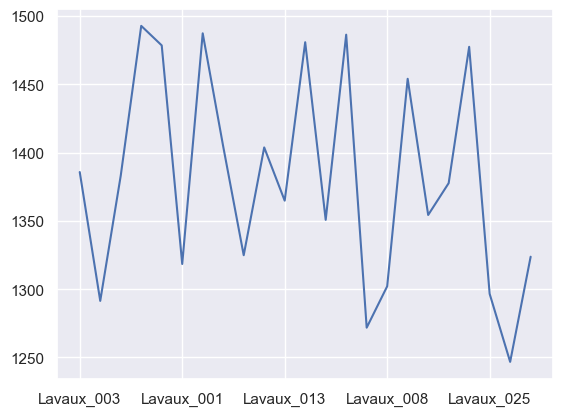

In [333]:
GDD_21.plot()


AttributeError: 'Series' object has no attribute 'boxplot'

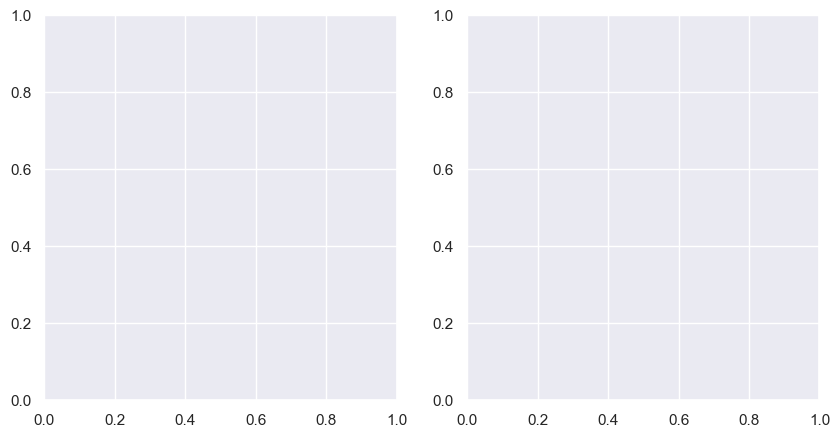

In [327]:
# two plots next to each other 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the first box plot on the first axes
GDD_21.plot.box()

# Create the second box plot on the second axes
GDD_22.boxplot(ax=axs[1])

# Set the title for each plot
axs[0].set_title('GDD 21')
axs[1].set_title('GDD 22')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## 1. Quality control 

--> remove outliers? 

## 2. Temperature differences

### Let's check out Temperatures in August! 

In [141]:
## compare temperature in August ?
df_Aug21 = df_temp[(df_temp.index > '2021-08-01 00:30:00') & (df_temp.index < '2021-08-31 23:00:00')]
df_Aug21.describe()

,Lavaux_003,Lavaux_017,Lavaux_016,Lavaux_002,Lavaux_028,Lavaux_001,Lavaux_015,Lavaux_029,Lavaux_004,Lavaux_006,...,Lavaux_009,Lavaux_020,Lavaux_008,Lavaux_030,Lavaux_024,Lavaux_018,Lavaux_019,Lavaux_025,Lavaux_032,Lavaux_026
count,2969.000000,1484.000000,742.000000,742.000000,742.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,...,1484.000000,1484.000000,1484.000000,1484.000000,742.000000,1484.000000,742.00000,1484.000000,1484.000000,1484.000000
mean,70.990353,72.398705,72.636080,70.605419,70.255976,72.277005,68.634679,71.445024,72.305218,70.393659,...,71.087606,71.707606,70.678795,69.936163,71.614667,69.174435,69.97862,70.781357,71.260008,70.291005
std,15.380939,16.092086,16.091468,15.221065,14.692965,15.159437,13.919965,14.542928,15.363104,14.412053,...,14.629029,15.916370,15.832139,14.509981,15.903467,12.885693,14.99306,15.126698,14.580175,15.476072
min,34.787000,36.329000,36.925000,32.586000,36.140000,40.855000,34.236000,39.227000,36.873000,39.897000,...,35.372000,36.262000,34.052000,37.756000,35.306000,38.369000,35.52000,36.063000,36.243000,36.364000
25%,59.661000,60.111000,60.288500,59.281500,59.077750,59.074000,58.377000,60.736000,60.751000,58.826000,...,59.837000,59.649000,58.711000,59.107000,60.238750,59.321000,58.76800,58.659000,60.675000,57.671000
50%,71.554000,74.043000,73.530000,70.757500,70.539500,74.071500,69.364000,71.036500,73.614500,70.224000,...,71.394500,73.218000,71.814000,70.613000,73.585000,70.636000,69.70300,70.973000,73.539500,70.946500
75%,81.939000,84.071000,84.304750,81.558500,81.142500,84.713000,78.282000,81.160000,82.959000,79.850000,...,82.668000,83.064000,82.206000,80.332000,83.882000,78.899000,80.73825,81.505000,82.699000,81.826000
max,99.301000,100.000000,99.863000,99.427000,99.070000,96.898000,95.576000,99.039000,99.109000,99.454000,...,95.448000,99.766000,98.951000,95.797000,96.552000,92.335000,99.68400,99.401000,92.641000,98.432000


In [142]:
df_Aug22 = df_temp[(df_temp.index > '2022-08-01 00:30:00') & (df_temp.index < '2022-08-31 23:00:00')]
df_Aug22.describe()

,Lavaux_003,Lavaux_017,Lavaux_016,Lavaux_002,Lavaux_028,Lavaux_001,Lavaux_015,Lavaux_029,Lavaux_004,Lavaux_006,...,Lavaux_009,Lavaux_020,Lavaux_008,Lavaux_030,Lavaux_024,Lavaux_018,Lavaux_019,Lavaux_025,Lavaux_032,Lavaux_026
count,0.0,742.000000,0.0,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,...,742.00000,742.000000,742.000000,742.000000,0.0,742.000000,0.0,742.000000,742.000000,742.000000
mean,NaN,61.242691,NaN,59.356252,60.821759,58.582612,60.006102,58.566931,60.823611,58.248018,...,61.19848,60.748443,59.798698,58.140985,NaN,58.278224,NaN,59.994309,60.468795,59.471807
std,NaN,19.064348,NaN,17.521564,16.608994,18.717591,16.579555,17.968420,18.853677,17.433593,...,17.09548,19.214111,18.695270,17.143474,NaN,16.744025,NaN,18.385956,17.772125,18.608763
min,NaN,19.319000,NaN,21.625000,20.366000,20.716000,21.576000,22.393000,16.949000,24.012000,...,22.93800,19.247000,19.155000,19.982000,NaN,21.523000,NaN,19.310000,20.571000,19.171000
25%,NaN,47.745000,NaN,46.057750,49.154250,44.646750,48.293500,45.670500,47.080250,45.412750,...,48.68400,46.905250,46.071000,46.275750,NaN,46.205500,NaN,46.678250,47.627250,45.839500
50%,NaN,59.913000,NaN,58.074500,60.156000,56.586500,59.984500,56.205000,59.891500,56.080500,...,60.07550,59.646000,58.410000,56.883000,NaN,57.720000,NaN,58.517000,59.668500,58.092000
75%,NaN,74.515500,NaN,71.266250,72.551500,73.594750,71.098750,71.363500,75.202500,71.245500,...,73.64450,74.487500,73.016500,71.074250,NaN,71.524000,NaN,72.871000,74.952250,72.419500
max,NaN,99.925000,NaN,98.545000,97.788000,92.612000,95.900000,98.418000,97.442000,97.491000,...,94.60500,99.447000,98.571000,93.646000,NaN,92.064000,NaN,98.776000,90.196000,98.142000


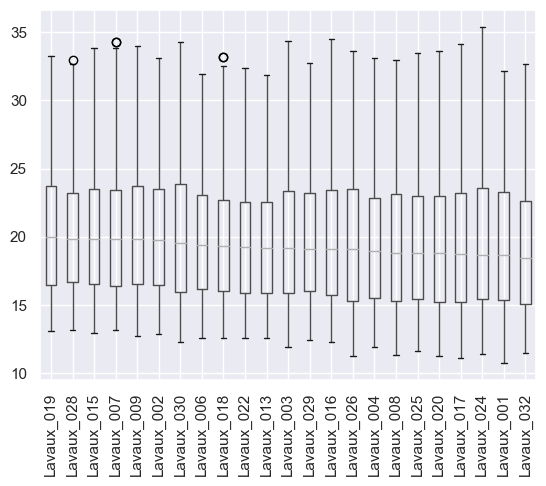

In [13]:
meds = df_Aug21.median()
meds.sort_values(ascending=False, inplace=True)
df_Aug = df_Aug[meds.index]
df_Aug.boxplot()

plt.xticks(rotation=90)

plt.show()


## Check out patterns in time 

In [122]:
df['hour'] = df.index.hour
df['month'] = df.index.month
df['yearday'] = df.index.dayofyear

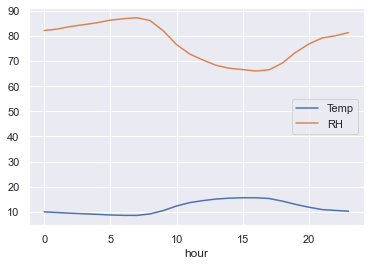

In [124]:
hourly_sst = df.Lavaux_001.groupby(df.hour).mean()
hourly_sst.plot();

## Unsupervised Clustering

-> https://towardsdatascience.com/hands-on-climate-time-series-clustering-using-machine-learning-with-python-6a12ce1607f9

In [741]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [762]:
# data preprocessing: get hourly mean and drop rows with NA 
df_temp_cluster = df_temp.resample('H').mean()
A = df_temp_cluster.shape[0]
df_temp_cluster = df_temp_cluster.dropna(axis=0) # drop rows with NA 
B = df_temp_cluster.shape[0]

# transpose 
data_array = np.array(df_temp_cluster.T.values)

print('Number of rows with NA dropped: ', A-B)


Number of rows with NA dropped:  12761


In [746]:
model = TimeSeriesKMeans(n_clusters=9, metric="dtw", max_iter=10)
model.fit(data_array)
plots_list = df_temp_cluster.T.index.tolist()

In [747]:
# apply the modell
y = model.predict(data_array)

# define our time step array
x = df_temp_cluster.index

/Users/lfloerl/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 23 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [785]:
k_dict = dict(zip(plots_list, clusters))
k_dict

{'Plot_18': 7,
 'Plot_15_3': 0,
 'Plot_4': 5,
 'Plot_17_1': 1,
 'Plot_17_5': 1,
 'Plot_12': 8,
 'Plot_17_4': 1,
 'Plot_20_3': 7,
 'Plot_9': 4,
 'Plot_20_5': 7,
 'Plot_20_1': 3,
 'Plot_5': 1,
 'Plot_20_2': 4,
 'Plot_17_3': 1,
 'Plot_15_1': 0,
 'Plot_15_4': 0,
 'Plot_14': 5,
 'Plot_11': 6,
 'Plot_20_4': 2,
 'Plot_17_2': 1,
 'Plot_15_5': 0,
 'Plot_13': 0,
 'Plot_15_2': 0}

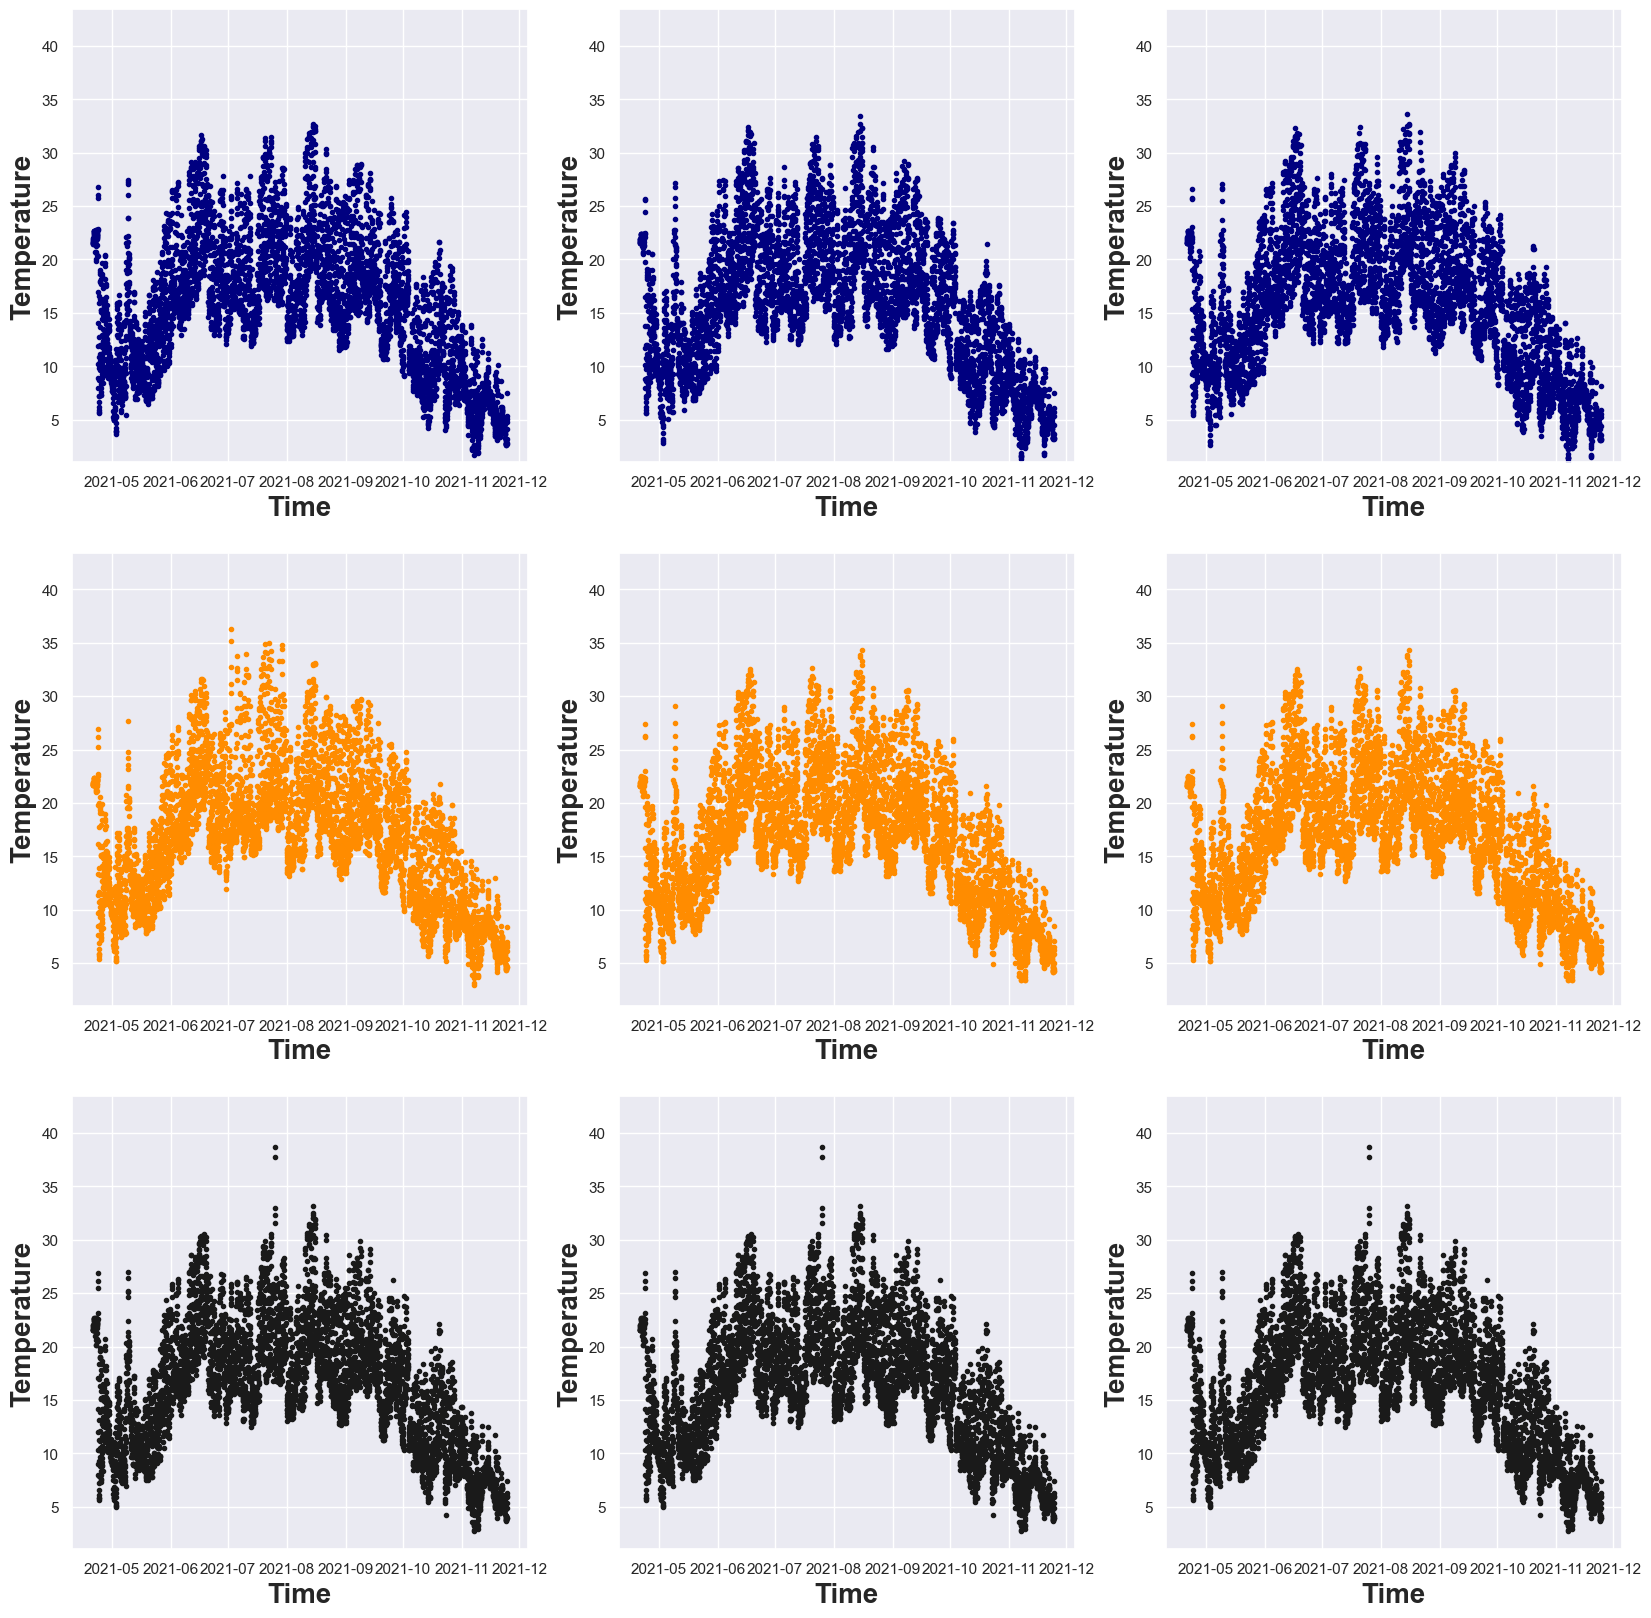

In [750]:
# Plotting
plt.figure(figsize=(20,20))
colors = ['navy']*3+['darkorange']*3+['k']*3
Names = ['Class 0']*3+['Class 1']*3+['Class 2']*3
for j in range(1,10):
    plt.subplot(3,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x,data_array[k],'.',color=colors[j-1])
    plt.ylabel('Temperature',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('City=%s, Class = %s'%(cities_list[k],Names[j-1]),fontsize=20)
    plt.ylim(data_array.min(),data_array.max())

KeyError: '10'

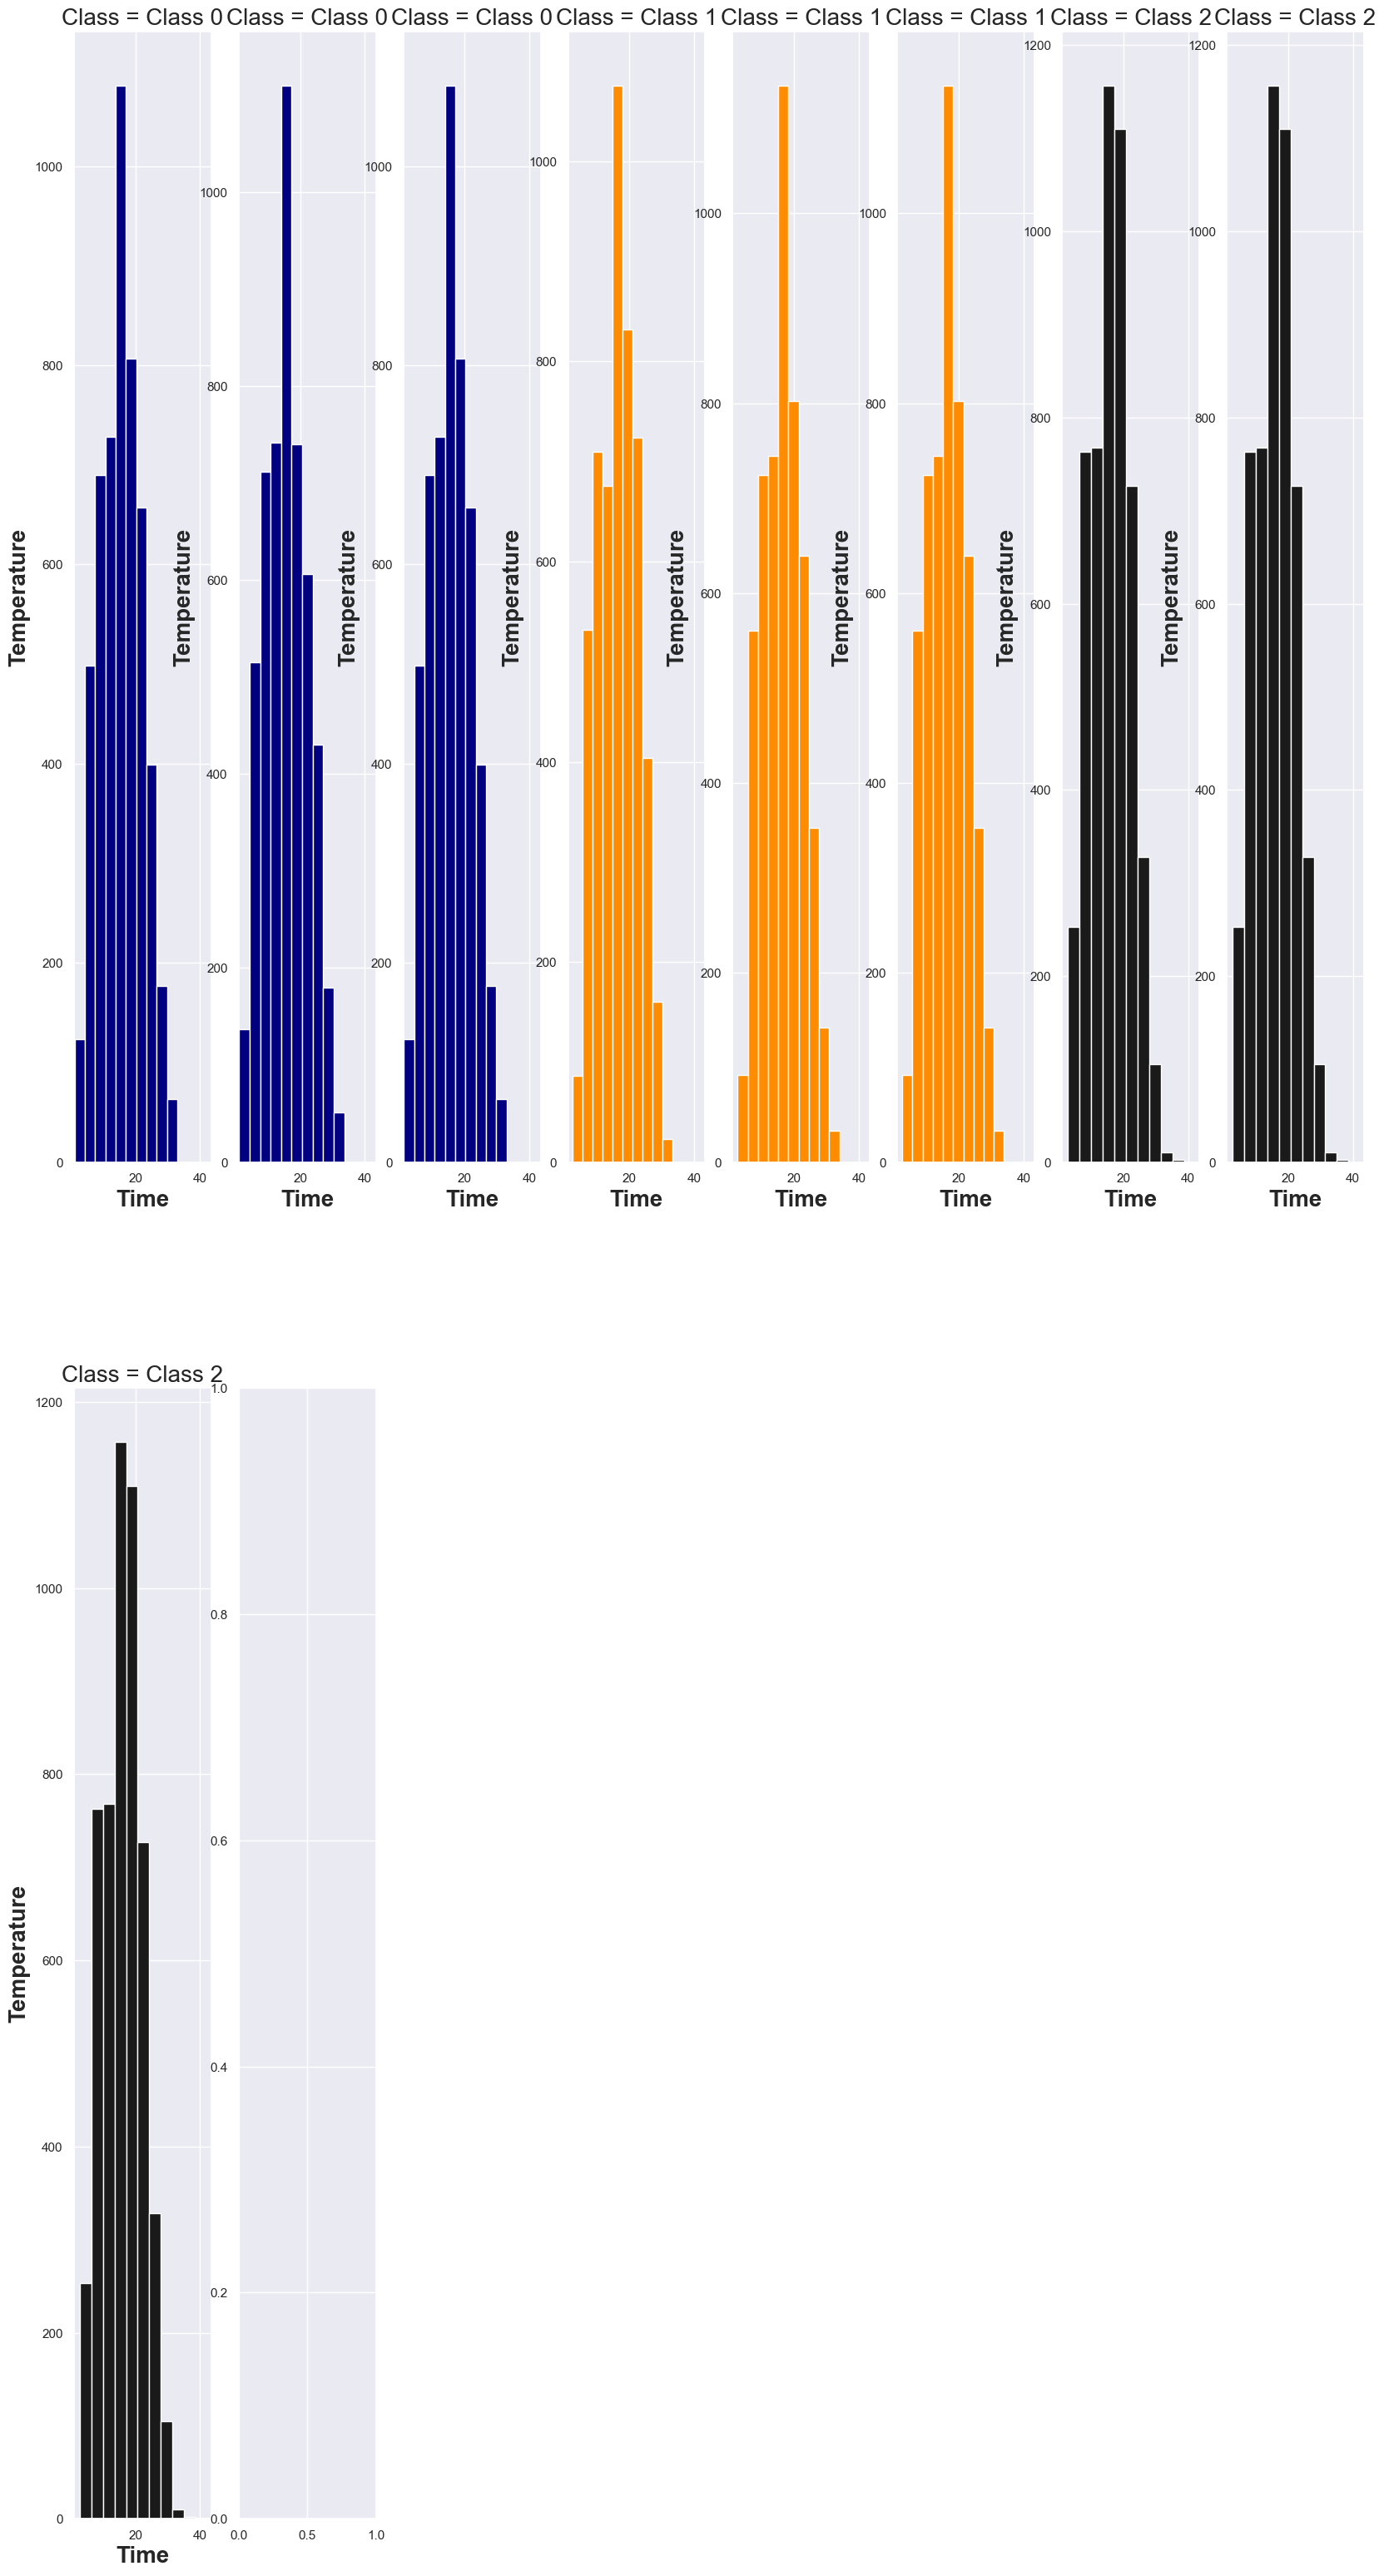

In [767]:
plt.figure(figsize=(20,60))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2}
 7, 0, 5, 1, 1, 8, 1, 7, 4, 7, 3, 1, 4, 1, 0, 0, 5, 6, 2, 1, 0, 0,
       0

colors = ['navy']*3+['darkorange']*3+['k']*3
Names = ['Class 0']*3+['Class 1']*3+['Class 2']*3
for j in range(1,23):
    plt.subplot(3,8,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.hist(data_array[k],color=colors[j-1])
    plt.ylabel('Temperature',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('Class = %s'%(Names[j-1]),fontsize=20)
    plt.xlim(data_array.min(),data_array.max())

==> DELETE THIS PART

In [735]:
df_temp_cluster = df_temp.resample('H').mean().dropna(axis=0)

df_temp_cluster

,Plot_18,Plot_15_3,Plot_4,Plot_17_1,Plot_17_5,Plot_12,Plot_17_4,Plot_20_3,Plot_9,Plot_20_5,...,Plot_17_3,Plot_15_1,Plot_15_4,Plot_14,Plot_11,Plot_20_4,Plot_17_2,Plot_15_5,Plot_13,Plot_15_2
2021-04-21 01:00:00,21.94500,21.843,21.891,21.939,22.011,22.034,21.915,22.106,21.963,22.034,...,22.106,22.082,22.034,21.939,21.891,22.034,22.058,21.963,22.058,21.987
2021-04-21 02:00:00,21.90300,21.819,21.819,21.915,21.939,22.011,21.867,22.058,21.891,21.987,...,22.034,21.987,21.939,21.891,21.819,21.987,21.987,21.915,21.963,21.939
2021-04-21 03:00:00,21.84300,21.795,21.748,21.891,21.867,21.963,21.795,22.011,21.843,21.915,...,21.963,21.915,21.819,21.819,21.748,21.891,21.915,21.891,21.867,21.891
2021-04-21 04:00:00,21.79525,21.748,21.652,21.843,21.795,21.939,21.748,21.939,21.772,21.843,...,21.867,21.819,21.700,21.748,21.652,21.795,21.819,21.819,21.772,21.843
2021-04-21 05:00:00,21.73600,21.700,21.581,21.819,21.724,21.891,21.676,21.891,21.724,21.772,...,21.795,21.748,21.604,21.676,21.557,21.724,21.748,21.748,21.676,21.795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24 11:00:00,5.60325,4.480,5.385,6.102,6.204,4.402,6.230,5.385,5.205,5.282,...,6.255,4.402,4.532,5.385,4.818,5.360,6.204,4.454,4.168,4.428
2021-11-24 12:00:00,5.85350,5.334,5.949,6.535,6.712,5.308,6.661,6.102,5.668,6.026,...,6.712,5.282,5.488,6.077,5.719,5.924,6.585,5.385,4.766,5.334
2021-11-24 13:00:00,6.01925,5.565,6.153,6.687,6.712,5.565,6.839,6.230,5.770,6.408,...,6.864,5.514,5.591,6.255,5.821,6.000,6.636,5.719,5.024,5.796
2021-11-24 14:00:00,6.31875,6.051,6.611,7.015,7.142,6.204,7.393,6.560,6.153,6.864,...,7.268,5.898,5.975,6.737,6.102,6.255,6.914,6.077,5.385,6.230


In [736]:
# Initialize the KMeans model with the desired number of clusters
kmeans = KMeans(n_clusters=10)

# Fit the model to the dataframe
kmeans.fit(df_temp_cluster.values)
clusters = kmeans.fit_predict(df_temp_cluster.transpose())
#kmeans.predict(df_temp_cluster)

# Get the cluster labels for each data point
#labels = kmeans.labels_

# Get the centroids of the clusters
#centroids = kmeans.cluster_centers_


# Add the cluster labels as a new column in the dataframe
#df_temp_cluster['Cluster'] = labels

ValueError: x and y must be the same size

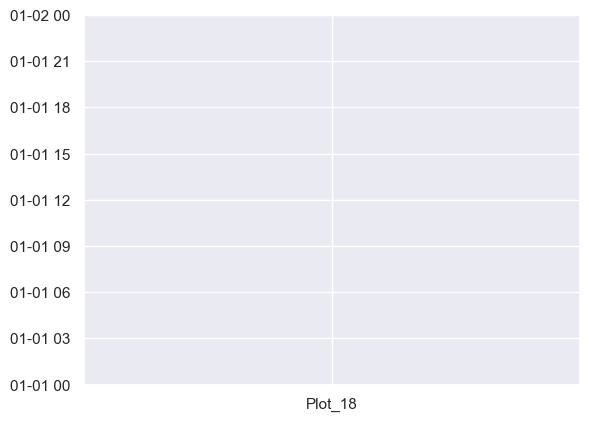

In [739]:
plt.scatter(df_temp_cluster.columns, df_temp_cluster.index, c=clusters)
plt.xlabel('Location')
plt.ylabel('Timestamp')
plt.title('K-means Clustering')
plt.xticks(rotation=90)
plt.show()

In [734]:
fig = plt.figure()
ax = fig.add_subplot(1,1, projection='3d')


# Plot the data points with cluster labels
for i, label in enumerate(labels):
    ax.scatter(df_temp_cluster.index[i], df_temp_cluster.columns, df_temp_cluster.iloc[i, :], c=label, cmap='viridis')

# Plot the centroids
#for centroid in centroids:
#    ax.scatter(df_temp_cluster.index[0], df_temp_cluster.columns, centroid, c='black', marker='X')

# Set labels and title
#ax.set_xlabel('Timestamp')
#ax.set_ylabel('Location')
#ax.set_zlabel('Value')
#ax.set_title('K-means Clustering of Data')

# Show the plot
plt.show()

TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

<Figure size 640x480 with 0 Axes>